## BI-PRS - Semestral Work 1 (samarrik's version)

### Code style & additional information (to be deleted)

**Headers:**
- # Work header
- ## The section, task
- ### Subtask

**Comments:**
- Major comments/descriptions are made in **markdown cells** with subtask definitions
- Smaller code-related comments are made directly in the code

**Images:**
- All images saved in the **./src/images** folder inside the project

**References:**
- References are made in text using [x], where **x** is a sequential number of a reference
- In the bottom of the notebook references are explained and specified using following template:

x. ***Source, Additional info, url***

### Country selection according to the representant's data

In [92]:
K <- 27
L <- nchar('bardatskii')
M <- ((K + L) * 47) %% 11 + 1

cat('Parameter M =', M, '=> Norsko, K.Dedecius')

Parameter M = 2 => Norsko, K.Dedecius

### Neccessary imports

In [93]:
.libPaths('~/stats/Rlib') # set up the path to your R library
#install.packages('...')   # install missing R packages

# Import relevant R packages
library(eurostat)
library(ggplot2)
library(tidyr)
library(tibble)
library(gridExtra)
library(cowplot)
library(repr)
library(vtable)

## Dataset preparation

- Download the dataset
- Describe the columns
- Extract relevant data

In [94]:
# Downloading the dataset
dataset <- get_eurostat(id='crim_gen_reg')

Dataset query already saved in cache_list.json...

Reading cache file /tmp/Rtmp52SmTC/eurostat/4ca88c492d9dacd6a9215347576d99fe.rds

Table  crim_gen_reg  read from cache file:  /tmp/Rtmp52SmTC/eurostat/4ca88c492d9dacd6a9215347576d99fe.rds



In [95]:
# First glance at the data we've received
head(dataset, 2)

freq,unit,iccs,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,NR,ICCS0101,AL,2008-01-01,88
A,NR,ICCS0101,AL,2009-01-01,82


#### Column description:

- **freq**: Frequency
- **unit**: Unit of measure
- **iccs**: International classification of crime for statistical purposes
- **geo**: Geopolitical entity (reporting)
- **TIME_PERIOD**: Time
 
[1]

#### Dataset completeness

There are no problems with the completeness of the data for the year 2021 from Norway.

![completeness](src/images/completeness.png)
[2]

#### Data units of measure explanation

We have multiple units of measure in this dataset. Let's clarify which ones we have here.

![units](src/images/units.png)
[3]

#### Relevant data selection and dataset transformations
- Norway NUTS3 regions
- Records for the year 2021
- Make separate columns for relative and absolute values
- Make columns iccs and geo factors

In [96]:
# Relative data selection
data <- dataset[startsWith(dataset$geo, 'NO') & (nchar(dataset$geo)==5),]
data <- data[data$TIME_PERIOD=='2021-01-01',]
data$freq <- NULL
data$TIME_PERIOD <- NULL

# Dataset transformation
data_by_unit <- split(data[,-1], data$unit)
data <- merge(x=data_by_unit$P_HTHAB, y=data_by_unit$NR, by=c('iccs', 'geo'), all=TRUE)  # Outer join
colnames(data)[3] <- 'rel'
colnames(data)[4] <- 'abs'

# Datatype transformations
data$iccs <- as.factor(data$iccs)
data$geo <- as.factor(data$geo)

head(data, 3)

,iccs,geo,rel,abs
,<fct>,<fct>,<dbl>,<dbl>
1,ICCS0101,NO020,0.00,0
2,ICCS0101,NO060,0.21,1
3,ICCS0101,NO071,0.00,0


#### Rename factor categories

![iccs_codes](src/images/iccs_codes.png)

[4] 

**Not provided in the dataset**:
- Assault (ICCS02011)
- Burglary (ICCS0501)
- Burglary of private residential premises (ICCS05012)

[2]

In [97]:
prev_labels <- c('ICCS0101', 'ICCS0401', 'ICCS0502', 'ICCS050211')
new_labels <- c('Int. homicide', 'Robbery', 'Theft', 'Theft of a m. l. vehicle')
data$iccs <- factor(data$iccs, levels=prev_labels, labels=new_labels)
head(data, 3)

,iccs,geo,rel,abs
,<fct>,<fct>,<dbl>,<dbl>
1,Int. homicide,NO020,0.00,0
2,Int. homicide,NO060,0.21,1
3,Int. homicide,NO071,0.00,0


## Exploratory data analysis & descriptive statistics

The data we have represent a number of crimes of each specific type for each NUTS3 Norway region represented in P_HTHAB (Per hundred thousand inhabitants) units. To analyse the following data, statistical measures and graphs will be used. As a result, we want to get insights about the criminality in different NUTS3 regions of Norway.

In [98]:
freq_table <- pivot_wider(data[, -4], names_from=iccs, values_from=rel) %>%
    column_to_rownames('geo') %>%
    as.matrix() %>%
    as.table()
names(dimnames(freq_table)) <- c('geo', 'iccs')
prob_table.row_cond <- prop.table(freq_table, margin=1)
prob_table.col_cond <- prop.table(freq_table, margin=2)

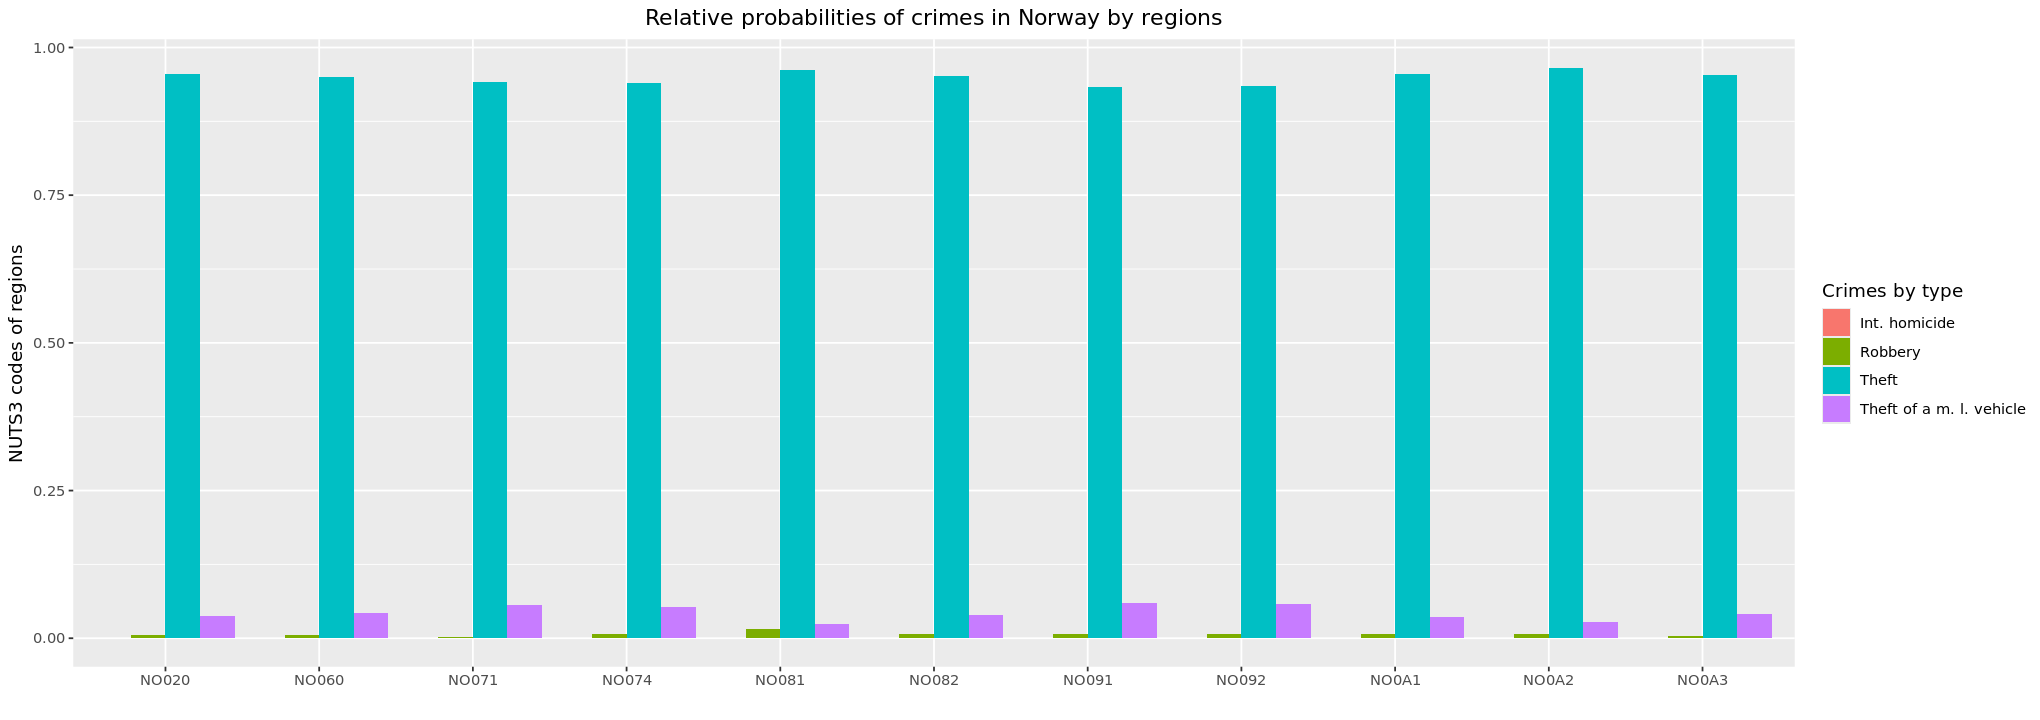

In [99]:
options(repr.plot.width=17, repr.plot.height=6) # Regulates the size of a plot [5]
ggplot(as.data.frame(prob_table.row_cond), aes(x=geo, y=Freq, fill=iccs)) +
    geom_bar(stat='identity', position='dodge') +
    labs( title='Relative probabilities of crimes in Norway by regions', x='', y='NUTS3 codes of regions', # Changes a title & axes of a plot
         fill="Crimes by type" ) + # Changes a title of a legend
    theme(plot.title = element_text(hjust=0.5)) # Centers a title of a plot

What we see from the plot upwards is that **without taking into account the criminality** of a particular NUTS3 region in Norway,
the **distribution of crimes by types** in all regions is **very similar**. That gives us an intuition (tests weren't conducted yet) that
**all crime types** are similarly distributed **in all regions.** We can see that **theft is the most likely-to-happen crime in all regions and an int. homicide is the most rare crime**.

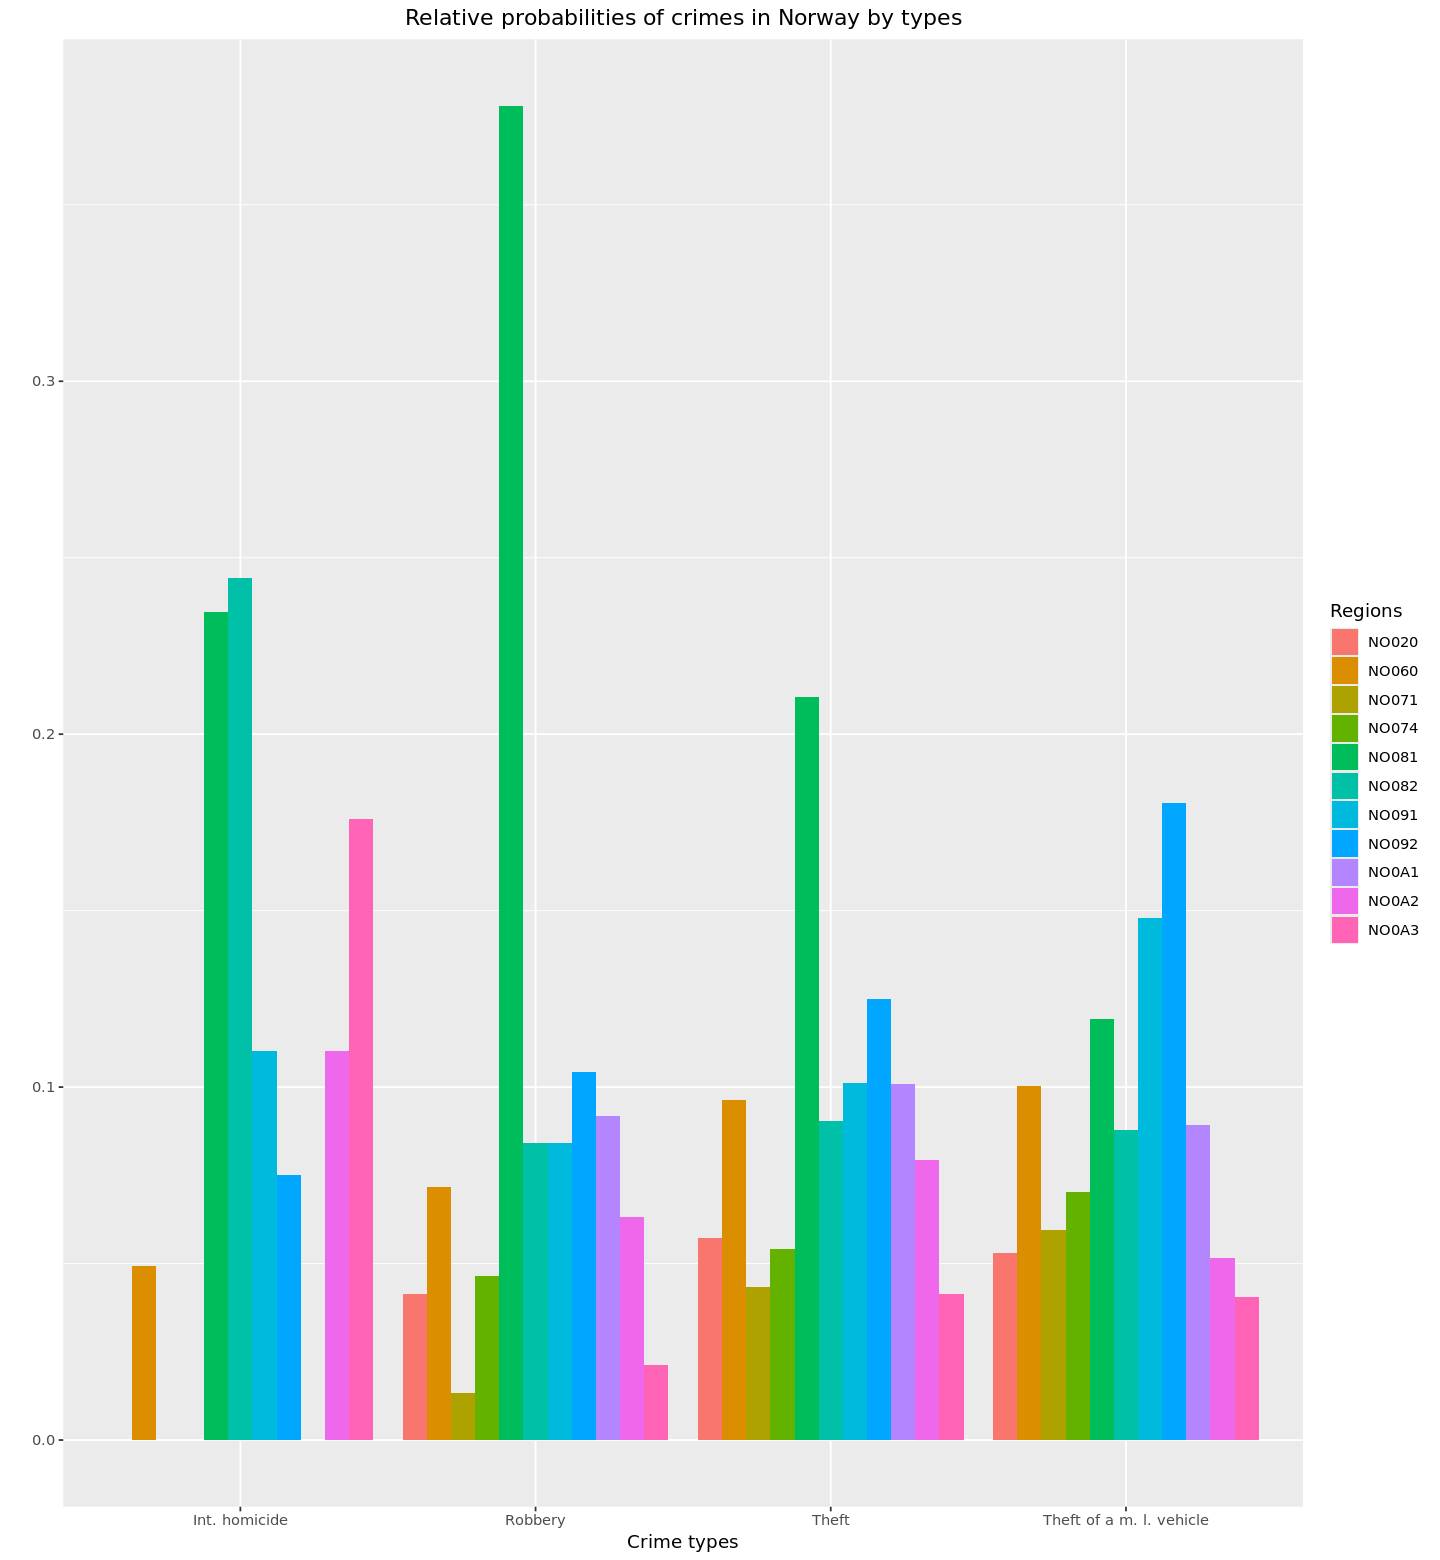

In [100]:
options(repr.plot.width=12, repr.plot.height=13) # Regulates the size of a plot [5]
ggplot(as.data.frame(prob_table.col_cond), aes(x=iccs, y=Freq, fill=geo)) +
    geom_bar(stat='identity', position='dodge') +
    labs( title='Relative probabilities of crimes in Norway by types', y='', x = 'Crime types', # Changes a title & axes of a plot
         fill="Regions" ) + # Changes a title of a legend
    theme(plot.title=element_text(hjust=0.5)) # Centers a title of a plot

This plot depicts a **distribution of probability** of crimes by types in regions of Norway. Looking at the probabilities of each crime happening in a specific region, we can highlight these facts which immediately catch the eye:

- **A robbery, a theft** is most likely to happen in **NO081**
- **An int. homicide** is most likely to happen in **NO082**
- **A theft of a vehicle** is most likely to happen in **NO092**

\* all statements are related to the year of 2021

## Contingency table

In [101]:
# TODO: Here it's time to say which region is the most criminal and which is the lest criminal one

## Hypotheses and tests

## References

1. ***Eurostat, Column description is located in 'About this dataset' section,*** https://ec.europa.eu/eurostat/databrowser/view/crim_gen_reg/default/table?lang=en&category=crim.crim_off
2. ***Eurostat, Dataset metadata (Completeness section)***, https://ec.europa.eu/eurostat/cache/metadata/en/crim_gen_reg_esms.htm
3. ***Eurostat, Dataset metadata (Unit of measure section)***, https://ec.europa.eu/eurostat/cache/metadata/en/crim_gen_reg_esms.htm
4. ***Eurostat, International classification od crime (codes)***, https://ec.europa.eu/eurostat/databrowser/view/crim_gen_reg/default/table?lang=en&category=crim.crim_off
5. ***Revolutions, Regulation of the size of a plot***, https://blog.revolutionanalytics.com/2015/09/resizing-plots-in-the-r-kernel-for-jupyter-notebooks.html
6.  
7.  
8.  
9.  
10.  